In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [4]:
import h5py

In [5]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [6]:
trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')
amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'

# Manually specify locations of interpolating nodes
namp = 20
nphase = 19
h = trainset[0]
amp_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), namp)
phase_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), nphase+1)
phase_mfs = np.delete(phase_mfs, 0)

print trainset.parameters().shape
print len(amp_mfs), amp_mfs
print len(phase_mfs), phase_mfs

(159, 5)
20 [ 0.00021     0.0002851   0.00038707  0.00052549  0.00071343  0.00096858
  0.00131498  0.00178526  0.00242373  0.00329054  0.00446735  0.00606503
  0.0082341   0.01117891  0.01517688  0.02060467  0.02797363  0.03797798
  0.05156024  0.07      ]
19 [ 0.0002851   0.00038707  0.00052549  0.00071343  0.00096858  0.00131498
  0.00178526  0.00242373  0.00329054  0.00446735  0.00606503  0.0082341
  0.01117891  0.01517688  0.02060467  0.02797363  0.03797798  0.05156024
  0.07      ]


In [7]:
nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
f = h5py.File(nodes_filename)
f['amp_mfs'] = amp_mfs
f['phase_mfs'] = phase_mfs
f.close()

159


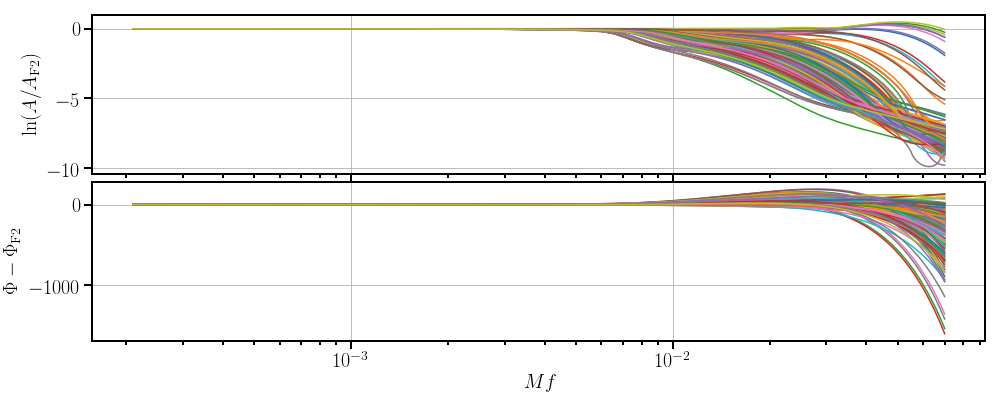

In [8]:
print len(trainset)

fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [9]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(amp_mfs)):
    mf = amp_mfs[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(phase_mfs)):
    mf = phase_mfs[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [10]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[  8.50406172e-04   1.86450266e+00   2.84899033e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.39581655e-08]
1
[  1.07886196e-03   1.87491961e+00   2.90275563e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.84307311e-08]
2
[  1.43139597e-03   1.87102978e+00   2.92268505e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   2.59302854e-08]
3
[  1.92978676e-03   1.87149026e+00   2.96290421e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   3.66657858e-08]
4
[  2.56682602e-03   1.86904671e+00   2.95675843e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   5.21134870e-08]
5
[  3.47957159e-03   1.87012941e+00   2.95361099e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   7.47213152e-08]
6
[  4.77212766e-03   1.86887016e+00   2.94252650e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.08349956e-07]
7
[  6.62329315e-03   1.85846128e+00   2.92303914e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.59785421e-07]
8
[  9.4

In [11]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, length_scale_factor=[0.1, 10.0], 
                                                             sigma_n_factor=[1.0e-6, 0.1])
    #print hyper_limits
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[  4.08584646e-03   1.12510711e+00   1.16053961e+00   3.00163687e+00
   1.71707291e+04   2.18449871e+04   4.90468007e-05]
1
[  2.84672408e-02   1.20692579e+00   1.37029650e+00   3.31357760e+00
   1.74753762e+04   2.70184462e+04   9.35703053e-05]
2
[  9.40490500e-02   1.28428442e+00   1.52564272e+00   3.65433819e+00
   1.90403693e+04   3.03502146e+04   2.49942578e-07]
3
[  2.32395357e-01   1.32147954e+00   1.64944446e+00   3.97822963e+00
   2.27135293e+04   3.20597659e+04   3.36738970e-07]
4
[  4.92342492e-01   1.35854012e+00   1.75944862e+00   4.26639901e+00
   2.60580282e+04   3.38247874e+04   9.18673571e-07]
5
[  9.56579987e-01   1.39940207e+00   1.86963005e+00   4.54882420e+00
   2.92982468e+04   3.57876883e+04   7.01152541e-07]
6
[  1.75930388e+00   1.44262711e+00   1.98519148e+00   4.83799506e+00
   3.26350758e+04   3.78986199e+04   1.16907206e-06]
7
[  3.12494744e+00   1.48670766e+00   2.11205540e+00   5.14661390e+00
   3.62547586e+04   4.01438615e+04   1.92547160e-06]
8
[  5.5

In [12]:
# Save GPR functions
gpr.save_gaussian_process_regression_list(amp_gp_filename, damp_gp_list, 'matern52')
gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'matern52')

# Test GPSplineSurrogate class

In [13]:
trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/h_train_corners_lhd.hdf5')
dtrainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')

#testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_test2.hdf5')
#dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_test2.hdf5')

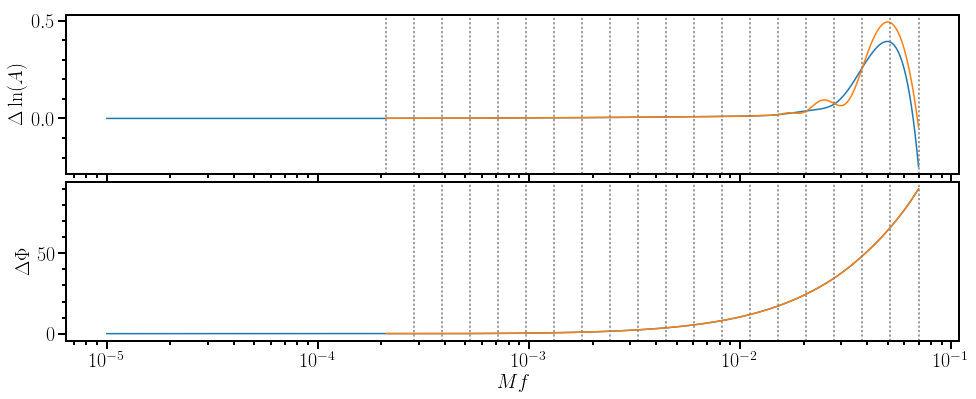

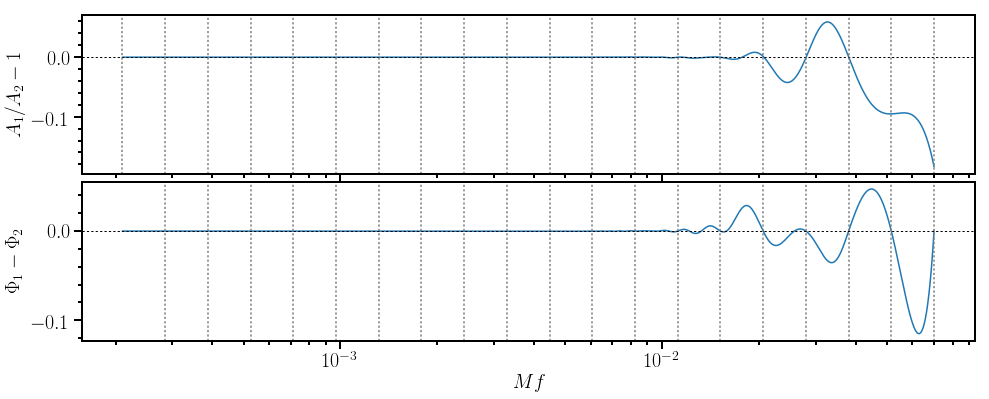

In [26]:
nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)


i = 28
htest = trainset[i]
dhtest = dtrainset[i]
params = dtrainset.get_waveform(i, data='parameters')

# i = 0
# dhtest = dtestset_rand[i]
# params = dtestset_rand.get_waveform(i, data='parameters')

hsur = sur.geometric_waveform(params)
hf2 = sur.geometric_reference_waveform(params)
dhsur = sur.amp_phase_difference(params)

# Resample
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
for mf in mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.01, 0.01)
# ax2.set_ylim(-1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
# ax1.set_ylim(-0.05, 0.05)
# ax2.set_ylim(-0.1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
# ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
# ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

(<matplotlib.figure.Figure at 0x11625aa50>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1172bb050>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1159d6f50>))

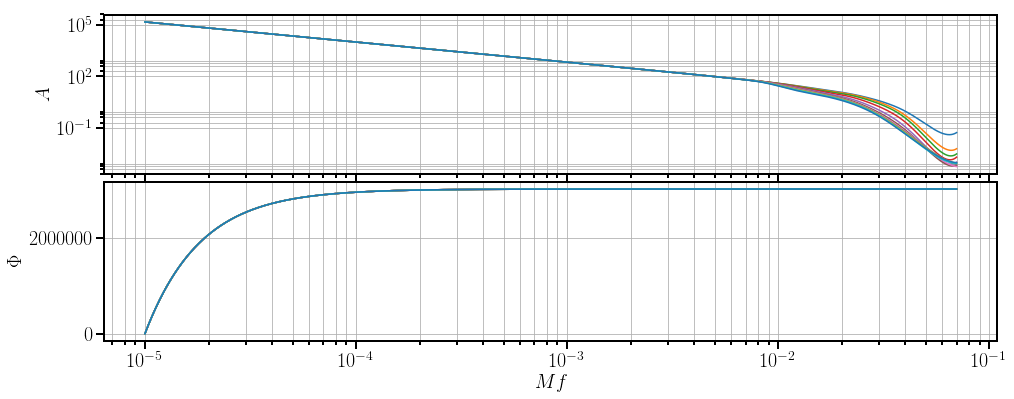

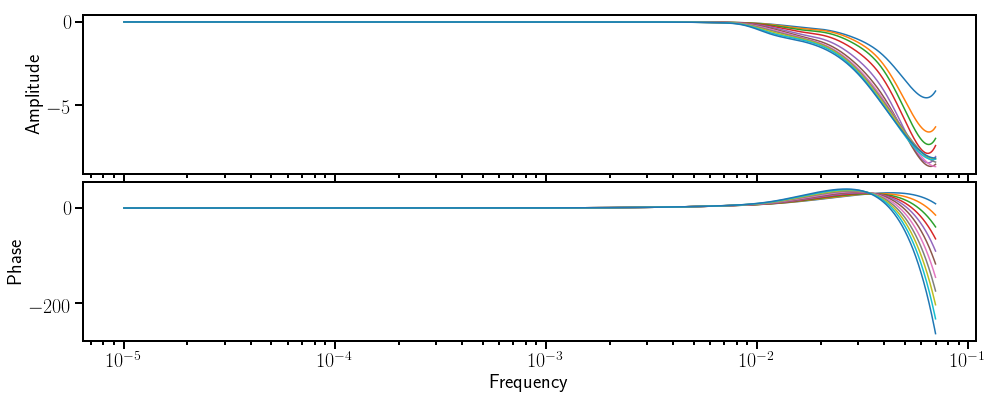

In [27]:
# Vary 1 parameter

q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0, 5000., 11)])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid(which='both')
ax2.grid(which='both')

wave.plot_waveforms_fd(dhs)